⚠️Clone the repository to use all the functions needed by the main code⚠️
---





In [2]:
try:
    import google.colab
    mode = 'colab'
except:
    mode = 'local'

if mode == 'colab':
    !git clone "https://github.com/cybernetic-m/nn-project.git"
else:
    print("You are running locally!")

You are running locally!


# IMPORT AND INITIALIZATION

In [5]:
# Import for config.yaml file
import hydra
from omegaconf import DictConfig
from omegaconf import OmegaConf

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import zipfile
import shutil
from IPython.display import Audio
import random

import torch
import torch.nn as nn
import torchaudio

from torch.utils.data import Dataset, DataLoader

if mode == 'colab':
    sys.path.append('/content/nn-project/dataloader')
    sys.path.append('/content/nn-project/model')
    sys.path.append('/content/nn-project/module')
    import gdown
    import utils
    import preprocessing
    import dataset
    import ctim

if mode == 'local':
    import dataloader.utils as utils
    import dataloader.dataset as dataset
    import dataloader.preprocessing as preprocessing 


In [ ]:
# Decorate the train() function
@hydra.main(config_path="../conf", config_name="config")
def train(conf: DictConfig):
    log.info(OmegaConf.to_yaml(conf))
    # Setup hyperparameters
    NUM_EPOCHS = conf.train.num_epochs
    BATCH_SIZE = conf.train.batch_size
    LEARNING_RATE = conf.train.learning_rate


Reproducibility

In [7]:
# Set the seed
seed = 10

# Set seed for torch, numpy and random libraries
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the devide mode on GPU (if available) or CPU
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"


## Download and Split Dataset

In [8]:
link_dataset = "https://drive.google.com/file/d/1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr/view?usp=drive_link"
gdrive_link = "https://drive.google.com/uc?export=download&id="

if mode == 'colab':
    destination_dir = "/content/emovo.zip"
    extract_dir = '/content/dataset'
    emovo_data_dir = '/content/dataset/EMOVO'
elif mode == 'local':
    destination_dir = "./emovo.zip"
    extract_dir = "./dataset"
    emovo_data_dir = "./dataset/EMOVO"

utils.download_dataset(link_dataset, destination_dir, gdrive_link, extract_dir)

utils.dataset_split(emovo_data_dir, extract_dir, 0.7, 0.2, 0.1)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr
From (redirected): https://drive.google.com/uc?export=download&id=1nzKBta2M3khw7Ql_S7atYg-H-bWDiOxr&confirm=t&uuid=f668b3a9-b09c-461a-bea7-bbbdd33feaa0
To: /Users/cyber_m/Desktop/Neural Network/nn-project/emovo.zip
100%|██████████| 253M/253M [00:08<00:00, 30.4MB/s] 
Unzipping...: 100%|██████████| 594/594 [00:01<00:00, 388.20it/s]


## Dataset Exploration

In [6]:
train_path = os.path.join(extract_dir, 'EMOVO_split', 'train')
test_path = os.path.join(extract_dir, 'EMOVO_split', 'test')
val_path = os.path.join(extract_dir, 'EMOVO_split', 'val')

train_dataset = dataset.EMOVO_Dataset(train_path)
test_dataset = dataset.EMOVO_Dataset(test_path)
val_dataset = dataset.EMOVO_Dataset(val_path)

Example of audio

Tensor of shape: torch.Size([2, 153600]) Sample Rate: 48000
Class: dis 



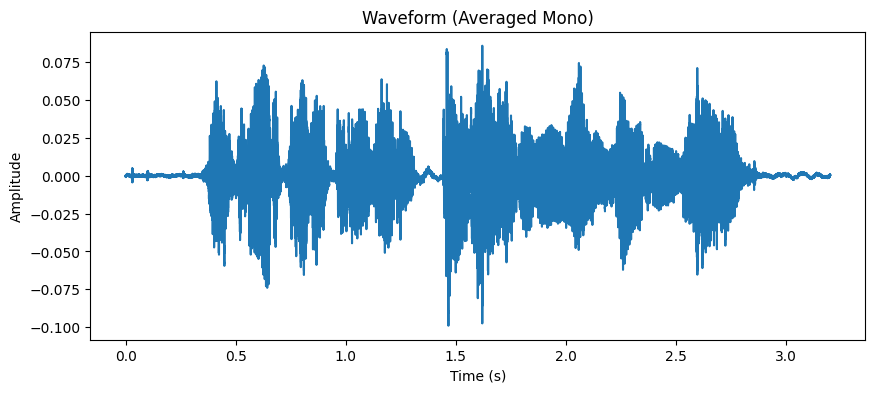

In [7]:
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']
random_num = random.randint(1, train_dataset.__len__())
data, label = train_dataset[random_num]

print("Tensor of shape:",data[0].shape, "Sample Rate:", data[1])
print("Class:", classes[label], "\n")

# Waveform
# Compute the average of both channels to get a mono waveform
mono_waveform = data[0].mean(dim=0)
num_samples = mono_waveform.shape[0]
sample_rate = data[1]
time_axis = np.linspace(0, num_samples / sample_rate, num_samples)

# Play the audio
display(Audio(mono_waveform.numpy(), rate=sample_rate))

# Plot the averaged (mono) waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mono_waveform.numpy())
plt.title('Waveform (Averaged Mono)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


Data distribution

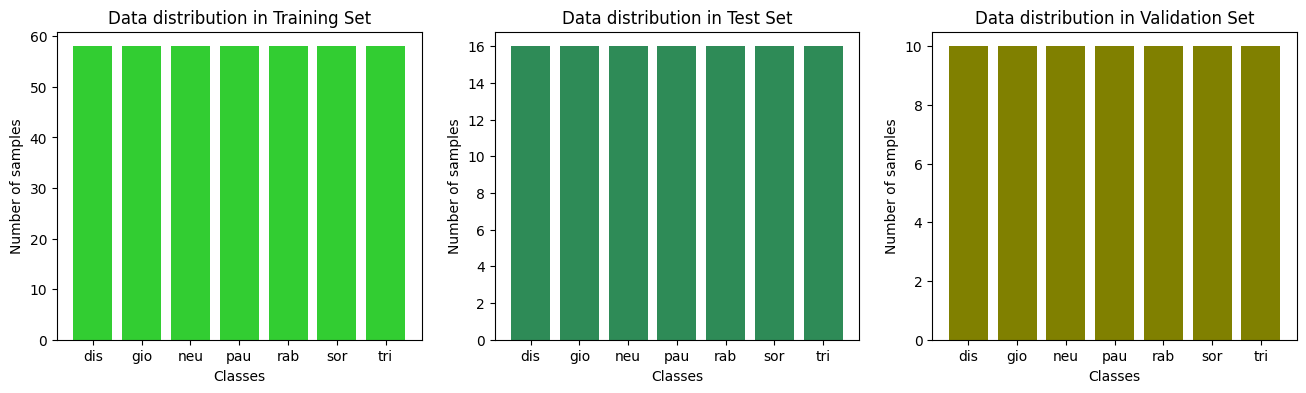

In [8]:
train_counts = train_dataset.get_info()
test_counts = test_dataset.get_info()
val_counts = val_dataset.get_info()
classes = ['dis', 'gio', 'neu', 'pau', 'rab', 'sor', 'tri']


fig, ax = plt.subplots(1,3, figsize=(16, 4))

ax[0].bar(classes, train_counts, color='limegreen')
ax[0].set_title("Data distribution in Training Set")
ax[0].set_xlabel("Classes")
ax[0].set_xticks(ticks=range(7), labels=classes)
ax[0].set_ylabel("Number of samples")

ax[1].bar(classes, test_counts, color='seagreen')
ax[1].set_title("Data distribution in Test Set")
ax[1].set_xlabel("Classes")
ax[1].set_xticks(ticks=range(7), labels=classes)
ax[1].set_ylabel("Number of samples")

ax[2].bar(classes, val_counts, color='olive')
ax[2].set_title("Data distribution in Validation Set")
ax[2].set_xlabel("Classes")
ax[2].set_xticks(ticks=range(7), labels=classes)
ax[2].set_ylabel("Number of samples")
plt.show()